# Example of Optimization solvers

This is an example of how to import data as a graph and solve it using MINLP solvers.

First, intiallize the environment with all the needed packages and build functions.

In [1]:
include("../optimizers/CustomProblem.jl")
include("../optimizers/CustomPlot.jl")
using .CustomProblem
using .CustomPlot
import JuMP
import JSON
import KNITRO
using PowerModelsDistribution
import PowerModelsONM
const _ONM = PowerModelsONM
const _PMD = PowerModelsDistribution
using Logging

Second, initiliaze the solver, in this example **Knitro** is used. Some open-source solvers useful for MINLP with non-linear inequality constraints are **Juniper**.

In [2]:
knitro_solver = JuMP.optimizer_with_attributes(KNITRO.Optimizer, 
                                               "ms_enable" => 0,
                                               "mip_multistart" => 0,
                                               "feastol" => 1e-3, 
                                               "outlev" => 4, 
                                               "bar_feasible" => 0, 
                                               "presolve" => 0,
                                               "convex" => 0,
                                               "mip_maxtimecpu" => 60)

MathOptInterface.OptimizerWithAttributes(KNITRO.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[MathOptInterface.RawOptimizerAttribute("ms_enable") => 0, MathOptInterface.RawOptimizerAttribute("mip_multistart") => 0, MathOptInterface.RawOptimizerAttribute("feastol") => 0.001, MathOptInterface.RawOptimizerAttribute("outlev") => 4, MathOptInterface.RawOptimizerAttribute("bar_feasible") => 0, MathOptInterface.RawOptimizerAttribute("presolve") => 0, MathOptInterface.RawOptimizerAttribute("convex") => 0, MathOptInterface.RawOptimizerAttribute("mip_maxtimecpu") => 60])

Import *.dss* data files.

In [3]:
disable_logging(LogLevel(1000)) #To avoid warnings
path = "../data/datasets/lanl4/"
case_math = _PMD.parse_file(path*"lanl4.dss"; data_model=MATHEMATICAL)
case_eng = _PMD.parse_file(path*"lanl4.dss"; data_model=ENGINEERING)
data = JSON.parsefile(path*"Knitro_lanl4.json")

Dict{String, Any} with 9 entries:
  "objective_lb"       => 2.88422e-8
  "optimizer"          => "Knitro"
  "termination_status" => "LOCALLY_SOLVED"
  "dual_status"        => "FEASIBLE_POINT"
  "primal_status"      => "FEASIBLE_POINT"
  "objective"          => -2.82694e-10
  "solution"           => Dict{String, Any}("branch"=>Dict{String, Any}("1"=>Di…
  "mip_gap"            => -2.91249e-8
  "solve_time"         => 0.702085

Run the custom problem. In this case **custom transmission loss**.

In [4]:
k=1; warmup=true
wrapped_function = (pm) -> CustomProblem.custom_problem_transmission_loss(pm, k, data, warmup)
solution = _PMD.solve_mc_model(case_math, _PMD.ACPUPowerModel, knitro_solver, wrapped_function; ref_extensions=[_ONM.ref_add_load_blocks!, _ONM.ref_add_options!])
JSON.print(solution,4)
println()

Power loss variable (y_variable) created!
Relax variable variable (z) created!
Variables defined!
Generators constraints defined
Balance constraints defined
Ohms constraints defined
Radiality constraints defined
McCormick linearization defined

             Trial License
       (NOT FOR COMMERCIAL USE)
         Artelys Knitro 14.0.0

         The Knitro mixed integer solver is designed for convex problems.
         For non-convex problems it is only a heuristic, and the reported
         bounds and optimality claims cannot be verified.

convex:                  0
datacheck:               0
feastol:                 0.001
hessian_no_f:            1
numthreads:              1
outlev:                  4
presolve:                0
mip_maxtime_cpu:         60
mip_numthreads:          1
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_rootalg from AUTO to 1.
Knitro changing mip_lpalg from AUTO to 3.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule fr

Let us save the solution.

In [5]:
open(path*"Knitro_lanl4.json", "w") do file
    JSON.print(file, solution)
end

Let us plot the solution.

Nodes: Any["671", "692", "675", "680"]
Lines: from 675 to 692
Lines: from 671 to 680
Lines: from 692 to 671
Adjacency: [0.0 -0.011999998836029896 0.0 0.0; 0.0 0.0 -0.006 0.0; 0.0 0.0 0.0 0.0; -0.017999999243448358 0.0 0.0 0.0]


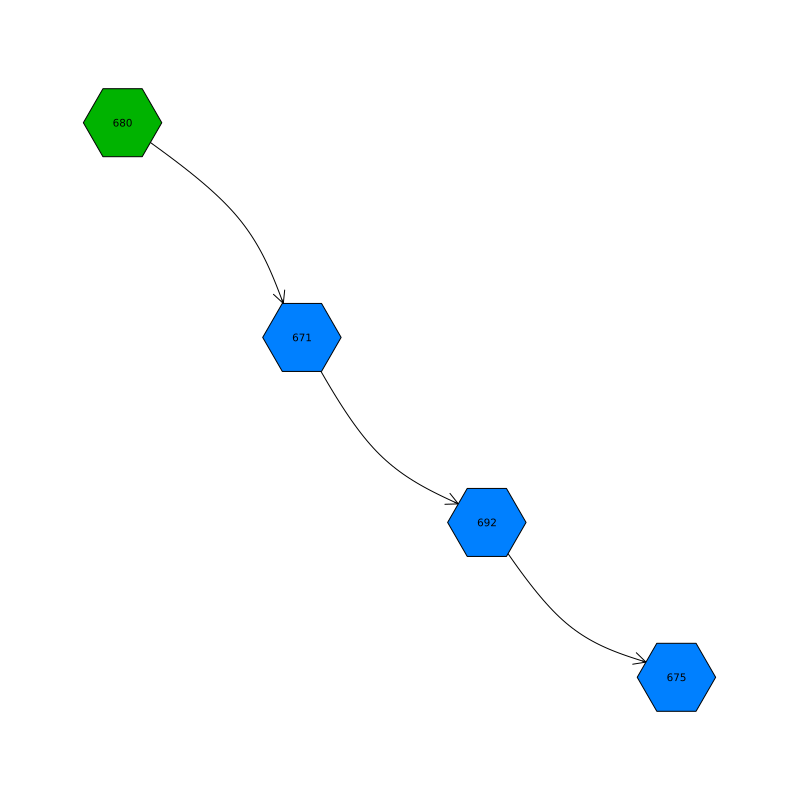

In [6]:
CustomPlot.custom_PMD_solution_plot(case_math, case_eng, solution)